<a href="https://colab.research.google.com/github/boz-tcm/happiness_atlas/blob/master/Project_2_Neural_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For Google Colab install the required laboratories
# !pip install pystan
# !pip install prophet
!pip install hvplot
!pip install holoviews

In [ ]:
# Imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import holoviews as hv
import hvplot.pandas
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import r2_score, mean_squared_error
#hv.extension('bokeh') # Reference: copy-paste to individual cells where necessary.

In [ ]:
# Import data file 'World Happiness Report 2005-2021 (1).csv'
from google.colab import files
uploaded = files.upload()

In [ ]:
# Create primary DataFrame from World Happiness Report 2005-2021 dataset.
happiness_df = pd.read_csv(Path('World Happiness Report 2005-2021 (1).csv'), parse_dates=True, index_col='Country name')

# Set DataFrame's index to 'country_name' to prepare for merge with supplemental dataset(s)
happiness_df.index.names=['country_name']
# Preview happiness_df
display(happiness_df)

,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
country_name,,,,,,,,,,,
Afghanistan,2008,3.723590,7.302574,0.450662,50.500000,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072
Afghanistan,2009,4.401778,7.472446,0.552308,50.799999,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545
Afghanistan,2010,4.758381,7.579183,0.539075,51.099998,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357
Afghanistan,2011,3.831719,7.552006,0.521104,51.400002,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386
Afghanistan,2012,3.782938,7.637953,0.520637,51.700001,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440
...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,2017,3.638300,8.241609,0.754147,52.150002,0.752826,-0.113937,0.751208,0.733641,0.224051,0.682647
Zimbabwe,2018,3.616480,8.274620,0.775388,52.625000,0.762675,-0.084747,0.844209,0.657524,0.211726,0.550508
Zimbabwe,2019,2.693523,8.196998,0.759162,53.099998,0.631908,-0.081540,0.830652,0.658434,0.235354,0.456455


In [ ]:
# Review primary source data happiness_df DataFrame for missing values.
# Frequency of nulls by field:
happiness_df_null_counts = happiness_df.isnull().sum()
display(happiness_df_null_counts)
# Most nulls are associated with 'Confidence in national government' and 'Perceptions of corruption'

Year                                   0
Life Ladder                            0
Log GDP per capita                    27
Social support                        13
Healthy life expectancy at birth      58
Freedom to make life choices          32
Generosity                            80
Perceptions of corruption            113
Positive affect                       24
Negative affect                       16
Confidence in national government    216
dtype: int64

In [ ]:
# Review further nulls associated with 'Confidence in national government':
display(happiness_df[happiness_df['Confidence in national government'].isnull()])
# Display frequency of 'Confidence in national government' nulls by country:
print(happiness_df[happiness_df['Confidence in national government'].isnull()].index.value_counts())
# Nulls for 'Confidence in national government' is associated with the usual suspects: China, Saudi Arabia, UAE, etc.
# Notwithstanding these nulls, the Life Ladder target value was reported in each case where a row \n
# had one or more nulls.
# Therefore, for the purposes of our analysis it would be reasonable and consistent to not drop entire rows where \n
# nulls exist for any given feature, and to instead rely on the remaining features in each row to explain the target.

,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
country_name,,,,,,,,,,,
Albania,2009,5.485470,9.241250,0.833047,67.320000,0.525223,-0.157363,0.863665,0.564474,0.279257,NaN
Albania,2010,5.268937,9.282614,0.733152,67.599998,0.568958,-0.171783,0.726262,0.576077,0.300060,NaN
Albania,2011,5.867422,9.310439,0.759434,67.879997,0.487496,-0.204296,0.877003,0.565759,0.256577,NaN
Algeria,2010,5.463567,9.302982,NaN,65.500000,0.592696,-0.207632,0.618038,NaN,NaN,NaN
Algeria,2011,5.317194,9.312737,0.810234,65.599998,0.529561,-0.182975,0.637982,0.502736,0.254897,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,2018,5.295547,8.934052,0.831945,65.199997,0.909260,-0.041581,0.808423,0.614404,0.191061,NaN
Vietnam,2019,5.467451,8.992331,0.847592,65.300003,0.952469,-0.126406,0.787889,0.657786,0.185610,NaN
Vietnam,2020,5.462342,9.011930,0.764510,65.400002,0.944707,0.085265,0.791134,0.699165,0.286374,NaN


China                      16
Saudi Arabia               16
United Arab Emirates       14
Jordan                     13
Bahrain                    11
Turkmenistan               10
Algeria                    10
Kuwait                     10
Morocco                     9
Egypt                       9
Vietnam                     8
Syria                       7
Uzbekistan                  7
Libya                       6
Laos                        5
Lebanon                     5
Rwanda                      5
Sudan                       5
Qatar                       4
Tajikistan                  4
Cambodia                    4
Serbia                      3
Albania                     3
Montenegro                  3
North Macedonia             3
Bosnia and Herzegovina      3
Kosovo                      3
Croatia                     3
Belarus                     2
Myanmar                     2
Burundi                     2
Pakistan                    2
Oman                        1
Turkey    

In [ ]:
# Import supplemental 'continents2.csv' which maps sub-region to country
from google.colab import files
uploaded = files.upload()

In [ ]:
# Create supplemental DataFrame 'regions_df' from imported data file that maps sub-region to country.
# Sub-regions may represent categorical variable that explains happiness.
regions_df = pd.read_csv(Path('continents2.csv'), parse_dates=True, index_col='name')

# Set supplemental (regions_df) DataFrame regions_df index to 'country_name' to prepare for merge with primary DataFrame happiness_df
regions_df.index.names=['country_name']
display(regions_df)

,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
country_name,,,,,,,,,,
Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...
Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NaN,9.0,61.0,NaN
Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NaN,2.0,15.0,NaN
Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NaN,142.0,145.0,NaN


In [ ]:
# Review regions DataFrame for missing values.
# Frequency of nulls by field:
regions_df_null_counts = regions_df.isnull().sum()
display(regions_df_null_counts)

alpha-2                       1
alpha-3                       0
country-code                  0
iso_3166-2                    0
region                        1
sub-region                    1
intermediate-region         142
region-code                   1
sub-region-code               1
intermediate-region-code    142
dtype: int64

In [ ]:
# Inspect regions DataFrame for missing country sub-region assignments.
display(regions_df[(regions_df['sub-region'].isnull())==True].head())
# Antarctica is the only country with a missing sub-region assignment.
# Antarctica is technically considered the only continent without a country.

,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
country_name,,,,,,,,,,
Antarctica,AQ,ATA,10,ISO 3166-2:AQ,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check to determine whether countries with missing sub-region assignments exist in primary source dataset happiness_df.
null_sub_regions_df=regions_df[(regions_df['sub-region'].isnull())==True]
display(happiness_df[happiness_df.index.isin(null_sub_regions_df.index.values)])
# Antarctica is the only country with missing sub-region, which can be ignored since we have determined that \n
# Antarctica does not exist in happiness_df.  Therefore, we can ignore the null sub-region in regions_df.


,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
country_name,,,,,,,,,,,


In [ ]:
# Augmenting primary DataFrame happiness_df with sub-regions column from regions_df.
# Merging happiness_df with regions_df sub-region column.
happiness_sub_regions_df = pd.merge(happiness_df, regions_df[['sub-region']], on='country_name', how='left')
display(happiness_sub_regions_df)

,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,sub-region
country_name,,,,,,,,,,,,
Afghanistan,2008,3.723590,7.302574,0.450662,50.500000,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072,Southern Asia
Afghanistan,2009,4.401778,7.472446,0.552308,50.799999,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545,Southern Asia
Afghanistan,2010,4.758381,7.579183,0.539075,51.099998,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357,Southern Asia
Afghanistan,2011,3.831719,7.552006,0.521104,51.400002,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386,Southern Asia
Afghanistan,2012,3.782938,7.637953,0.520637,51.700001,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440,Southern Asia
...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,2017,3.638300,8.241609,0.754147,52.150002,0.752826,-0.113937,0.751208,0.733641,0.224051,0.682647,Sub-Saharan Africa
Zimbabwe,2018,3.616480,8.274620,0.775388,52.625000,0.762675,-0.084747,0.844209,0.657524,0.211726,0.550508,Sub-Saharan Africa
Zimbabwe,2019,2.693523,8.196998,0.759162,53.099998,0.631908,-0.081540,0.830652,0.658434,0.235354,0.456455,Sub-Saharan Africa


In [ ]:
print(f"There are {len(happiness_sub_regions_df.index.unique())} countries and {len(happiness_sub_regions_df['sub-region'].unique())} sub-regions in our global happiness dataset.")

There are 166 countries and 15 sub-regions in our global happiness dataset.


In [ ]:
# Create copy of happiness_sub_regions_df prior to making any adjustments, such as filling nulls, in the primary dataset
happiness_df_cleaning = happiness_sub_regions_df.copy()
#display(happiness_df_clean)




# # Determine averages by sub-region and year for each field that we may use as proxies to replace feature \n
# # nulls by country and year.
# # Filter happiness DataFrame for rows that have one or more nulls:
# happiness_nulls_df = happiness_df[happiness_df.isnull().any(axis=1)]
# display(happiness_nulls_df)

In [ ]:

#display(happiness_df_clean[happiness_df_clean['Log GDP per capita'].isnull()])
display(happiness_df_cleaning[happiness_df_cleaning.index == 'Afghanistan'])
display(happiness_df_cleaning[happiness_df_cleaning.index == 'Somaliland region'])
happiness_df_cleaning['Log GDP per capita'] = happiness_df_cleaning['Log GDP per capita'].fillna(method='ffill')
display(happiness_df_cleaning[happiness_df_cleaning.index == 'Afghanistan'])
display(happiness_df_cleaning[happiness_df_cleaning.index == 'Somaliland region'])


,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,sub-region
country_name,,,,,,,,,,,,
Afghanistan,2008,3.723590,7.302574,0.450662,50.500000,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072,Southern Asia
Afghanistan,2009,4.401778,7.472446,0.552308,50.799999,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545,Southern Asia
Afghanistan,2010,4.758381,7.579183,0.539075,51.099998,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357,Southern Asia
Afghanistan,2011,3.831719,7.552006,0.521104,51.400002,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386,Southern Asia
Afghanistan,2012,3.782938,7.637953,0.520637,51.700001,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440,Southern Asia
Afghanistan,2013,3.572100,7.657503,0.483552,52.000000,0.577955,0.066344,0.823204,0.547417,0.273328,0.482847,Southern Asia
Afghanistan,2014,3.130896,7.650827,0.525568,52.299999,0.508514,0.109215,0.871242,0.491641,0.374861,0.409048,Southern Asia
Afghanistan,2015,3.982855,7.634466,0.528597,52.599998,0.388928,0.085082,0.880638,0.491410,0.339276,0.260557,Southern Asia
Afghanistan,2016,4.220169,7.629037,0.559072,52.924999,0.522566,0.047488,0.793246,0.501409,0.348332,0.324990,Southern Asia


,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,sub-region
country_name,,,,,,,,,,,,
Somaliland region,2009,4.991400,NaN,0.879567,NaN,0.746304,NaN,0.513372,0.707874,0.112012,0.538495,NaN
Somaliland region,2010,4.657363,NaN,0.829005,NaN,0.820182,NaN,0.471094,0.631947,0.083426,0.587192,NaN
Somaliland region,2011,4.930572,NaN,0.787962,NaN,0.858104,NaN,0.357341,0.690514,0.122244,0.760764,NaN
Somaliland region,2012,5.057314,NaN,0.786291,NaN,0.758219,NaN,0.333832,0.686732,0.152428,0.651242,NaN


,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,sub-region
country_name,,,,,,,,,,,,
Afghanistan,2008,3.723590,7.302574,0.450662,50.500000,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072,Southern Asia
Afghanistan,2009,4.401778,7.472446,0.552308,50.799999,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545,Southern Asia
Afghanistan,2010,4.758381,7.579183,0.539075,51.099998,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357,Southern Asia
Afghanistan,2011,3.831719,7.552006,0.521104,51.400002,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386,Southern Asia
Afghanistan,2012,3.782938,7.637953,0.520637,51.700001,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440,Southern Asia
Afghanistan,2013,3.572100,7.657503,0.483552,52.000000,0.577955,0.066344,0.823204,0.547417,0.273328,0.482847,Southern Asia
Afghanistan,2014,3.130896,7.650827,0.525568,52.299999,0.508514,0.109215,0.871242,0.491641,0.374861,0.409048,Southern Asia
Afghanistan,2015,3.982855,7.634466,0.528597,52.599998,0.388928,0.085082,0.880638,0.491410,0.339276,0.260557,Southern Asia
Afghanistan,2016,4.220169,7.629037,0.559072,52.924999,0.522566,0.047488,0.793246,0.501409,0.348332,0.324990,Southern Asia


,Year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,sub-region
country_name,,,,,,,,,,,,
Somaliland region,2009,4.991400,6.778198,0.879567,NaN,0.746304,NaN,0.513372,0.707874,0.112012,0.538495,NaN
Somaliland region,2010,4.657363,6.778198,0.829005,NaN,0.820182,NaN,0.471094,0.631947,0.083426,0.587192,NaN
Somaliland region,2011,4.930572,6.778198,0.787962,NaN,0.858104,NaN,0.357341,0.690514,0.122244,0.760764,NaN
Somaliland region,2012,5.057314,6.778198,0.786291,NaN,0.758219,NaN,0.333832,0.686732,0.152428,0.651242,NaN


In [ ]:
# Make a copy of our cleaned DataFrame to use as basis for preprocessing and modeling
happiness_df_clean = happiness_sub_regions_df.copy().dropna()
# Verify cleaned DataFrame has no outstanding nulls
happiness_df_clean.isnull().sum()

Year                                 0
Life Ladder                          0
Log GDP per capita                   0
Social support                       0
Healthy life expectancy at birth     0
Freedom to make life choices         0
Generosity                           0
Perceptions of corruption            0
Positive affect                      0
Negative affect                      0
Confidence in national government    0
sub-region                           0
dtype: int64

## Separate the Features (X) from the Target (y)

In [ ]:
# Segment the features from the target
# Identify the 'y' target(s)
y = happiness_df_clean["Life Ladder"]
# Identify the 'X' features
X = happiness_df_clean.drop(columns=['Life Ladder', 'Year']).reset_index()

In [ ]:
# One-Hot encode cat columns

# Create a list of categorical variables, filtering out numerical fields and leaving categorical fields
cat_vars = list(X.dtypes[X.dtypes=='object'].index)
#print(cat_vars)

# Create the categorical features DataFrame
X_categorical_df = X[cat_vars]
# display(X_categorical_df)

# Instantiate the one-hot encoding standardizing object
encoder = OneHotEncoder(sparse=False) #!Important -> Must use 'sparse=False' for object to execute

# Apply fit and transform to categorical features DataFrame
X_categorical_encoder_fit = encoder.fit(X_categorical_df)
X_categorical_encoded = X_categorical_encoder_fit.transform(X_categorical_df)
# Create encoded DataFrame following transform.  The encoder will generate new categorical columns which must be extracted using get_features_names_out().
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns = encoder.get_feature_names_out(cat_vars))
# display(X_categorical_encoded_df)

# Recombine X categorical encoded with X numerical scaled fields
X_numerical_df = X.drop(columns=cat_vars)
# display(X_numerical_df)
X_standardized_recombined_df = pd.concat([X_categorical_encoded_df, X_numerical_df], axis=1)
display(X_standardized_recombined_df.head(20))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,country_name_Afghanistan,country_name_Albania,country_name_Angola,country_name_Argentina,country_name_Armenia,country_name_Australia,country_name_Austria,country_name_Azerbaijan,country_name_Bangladesh,country_name_Belarus,...,sub-region_Western Europe,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.302574,0.450662,50.500000,0.718114,0.173169,0.881686,0.414297,0.258195,0.612072
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.472446,0.552308,50.799999,0.678896,0.195469,0.850035,0.481421,0.237092,0.611545
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.579183,0.539075,51.099998,0.600127,0.125859,0.706766,0.516907,0.275324,0.299357
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.552006,0.521104,51.400002,0.495901,0.167723,0.731109,0.479835,0.267175,0.307386
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.637953,0.520637,51.700001,0.530935,0.241247,0.775620,0.613513,0.267919,0.435440
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.657503,0.483552,52.000000,0.577955,0.066344,0.823204,0.547417,0.273328,0.482847
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.650827,0.525568,52.299999,0.508514,0.109215,0.871242,0.491641,0.374861,0.409048
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.634466,0.528597,52.599998,0.388928,0.085082,0.880638,0.491410,0.339276,0.260557
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.629037,0.559072,52.924999,0.522566,0.047488,0.793246,0.501409,0.348332,0.324990
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.629684,0.490880,53.250000,0.427011,-0.116068,0.954393,0.435270,0.371326,0.261179


In [ ]:
# Split features and target into train and test datasets (default split approximately 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_standardized_recombined_df, y, random_state=1)
print(X_train.info(), "\n")
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 991 to 1061
Columns: 164 entries, country_name_Afghanistan to Confidence in national government
dtypes: float64(164)
memory usage: 1.6 MB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 857 to 421
Columns: 164 entries, country_name_Afghanistan to Confidence in national government
dtypes: float64(164)
memory usage: 541.4 KB
None


In [ ]:
"""DELETE UPON FINAL
# # use the x_train
# # separate numeric and cat columns
# X_train_numerical_df = X_train.drop(columns=['country_name', 'sub-region'])
# X_train_numerical_df

# X_test_numerical_df = X_test.drop(columns=['country_name', 'sub-region'])
# X_test_numerical_df

# #print(num_vars)

# X_train_categorical_df = X_train[['country_name', 'sub-region']]
# X_train_categorical_df

# X_test_categorical_df = X_test[['country_name', 'sub-region']]
# X_test_categorical_df
"""

# Standardize numerical features columns

# Create a list of numerical variables
num_vars = X_train.columns

# Instantiate the scalar standardizing object(s)
# If we had more time, we would explore the distribution of data for each numercial \n
# feature, and use the appropriate scalar function.  For example, for features roughly
# normally distributed, we would use StandardScalar(); for features not normally distributed, \n
# either heavily skewed or uniformally distributed, we might use MinMaxScaler(), unless sparse \n
# dataset in which we might use MaxAbsScaler instead.
# Assuming numerical features are generally roughly normally distributed, we will scale \n
# all numerical features using StandardScaler():
scaler = StandardScaler()

# Apply fit and transform to numerical features X_train DataFrame
X_train_numerical_scaler_fit = scaler.fit(X_train)
X_train_numerical_scaled = X_train_numerical_scaler_fit.transform(X_train)
# display(X_train_numerical_scaled)
# Create X_train scaled DataFrame following transform.
X_train_numerical_scaled_df = pd.DataFrame(X_train_numerical_scaled, columns = num_vars)
# display(X_train_scaled_numerical_df)

# Apply transform to numerical features X_test DataFrame using the StandardScaler() fit for X_train
X_test_numerical_scaled = X_train_numerical_scaler_fit.transform(X_test)
# Create scaled X_test DataFrame following transform.
X_test_numerical_scaled_df = pd.DataFrame(X_test_numerical_scaled, columns = num_vars)
display(X_test_numerical_scaled_df)

"""DELETE UPON FINAL
# # one hot encode cat columns
# # fit transformed on  x_train
# encoder = OneHotEncoder(sparse=False) #!Important
# X_train_encoder_fit = encoder.fit(X_train_categorical_df)
# X_train_encoded = X_train_encoder_fit.transform(X_train_categorical_df)
# X_train_encoded_df = pd.DataFrame(X_train_encoded, columns = encoder.get_feature_names_out(cat_vars))
# # display(X_train_encoded_df)

# X_test_encoded = X_train_encoder_fit.transform(X_test_categorical_df)
# X_test_encoded_df = pd.DataFrame(X_test_encoded, columns = encoder.get_feature_names_out(cat_vars))

# # combine processed cat and numeric columns as the final dataset
# X_train_final_df = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
# display(X_train_final_df)

# X_test_final_df = pd.concat([X_test_scaled_df, X_tested_encoded_df], axis=1)
# display(X_test_final_df)
"""

,country_name_Afghanistan,country_name_Albania,country_name_Angola,country_name_Argentina,country_name_Armenia,country_name_Australia,country_name_Austria,country_name_Azerbaijan,country_name_Bangladesh,country_name_Belarus,...,sub-region_Western Europe,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government
0,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,0.606634,0.980664,0.066867,-1.346740,-1.856689,1.157936,-0.892659,-0.177185,-1.474117
1,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,0.734723,0.808068,0.572726,-1.122420,-0.332225,0.882293,-0.463721,0.094738,-1.073209
2,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,0.634309,0.641148,-0.112809,0.220345,-1.449868,0.384340,-0.303944,-1.258950,0.875010
3,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,1.188612,1.171813,1.075819,1.334284,1.399025,-1.760874,1.223490,-0.429469,0.304054
4,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,-1.286549,-2.999248,-1.528106,-1.253048,-0.085072,0.225676,-1.323591,0.488416,0.252158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,-0.697438,0.055787,-1.503228,-0.729413,0.391583,0.807990,1.135478,-0.719537,-0.969916
416,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,0.735580,0.924957,0.663945,0.905900,-0.424638,0.793825,0.186281,-0.555930,-1.232615
417,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,0.166908,0.487933,-1.087208,0.263021,-0.861566,0.620241,0.447297,-0.005935,-0.353750
418,-0.084887,-0.084887,-0.056478,-0.106085,-0.084887,-0.093921,-0.093921,-0.089514,-0.08,-0.084887,...,-0.239046,-0.573318,-0.048439,-0.195737,1.037457,0.184552,0.344625,1.577306,0.305026,0.319396


'DELETE UPON FINAL\n# # one hot encode cat columns\n# # fit transformed on  x_train\n# encoder = OneHotEncoder(sparse=False) #!Important\n# X_train_encoder_fit = encoder.fit(X_train_categorical_df)\n# X_train_encoded = X_train_encoder_fit.transform(X_train_categorical_df)\n# X_train_encoded_df = pd.DataFrame(X_train_encoded, columns = encoder.get_feature_names_out(cat_vars))\n# # display(X_train_encoded_df)\n\n# X_test_encoded = X_train_encoder_fit.transform(X_test_categorical_df)\n# X_test_encoded_df = pd.DataFrame(X_test_encoded, columns = encoder.get_feature_names_out(cat_vars))\n\n# # combine processed cat and numeric columns as the final dataset\n# X_train_final_df = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)\n# display(X_train_final_df)\n\n# X_test_final_df = pd.concat([X_test_scaled_df, X_tested_encoded_df], axis=1)\n# display(X_test_final_df)\n'

In [ ]:
# Create copies of X_train and X_test DataFrames to use in modeling
X_train = X_train_numerical_scaled_df.copy()
X_test = X_test_numerical_scaled_df.copy()

 ## Create an SVM SVR Regression Model

In [ ]:
# From SVM, instantiate SVR regression model instance.
# According to instructor, the SVM model employs a hyperplane to bisect and segregate the data, and is a bit more effective than a logistics model.
# "It's been shown that the linear kernel is a degenerate version of RBF, hence the linear kernel is never more accurate than a properly tuned RBF kernel," \n
# c.f. https://stats.stackexchange.com/questions/73032/linear-kernel-and-non-linear-kernel-for-support-vector-machine
# The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression.
# As with classification classes, the fit method will take as argument vectors X, y, only that in this case y is expected to have floating point values \n
# instead of integer values. c.f. https://scikit-learn.org/stable/modules/svm.html
# Visuals of linear and non-linear Support Vector Regression fitting: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py

In [ ]:
# Instantiate an SVM regression model
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf')

 ### Fit (train) our model using the training data.  Make predictions and evaluate our model.

In [ ]:
# Fit the Data
svr_model = svr_model.fit(X_train, y_train)
# display(X_train)
# display(y_train)

In [ ]:

y_train_predictions = svr_model.predict(X_train)
train_results = pd.DataFrame({"Prediction": y_train_predictions, "Actual": y_train}).reset_index(drop=True)
display(train_results)

,Prediction,Actual
0,5.855568,5.803451
1,4.324459,4.224534
2,6.886303,7.074325
3,7.266977,7.305014
4,4.460279,4.224593
...,...,...
1253,7.176780,7.433148
1254,3.711079,3.869124
1255,5.809607,6.275267
1256,4.185790,3.883306


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
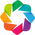

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
# Plot train results predictions vs actual
hv.extension('bokeh')
train_results_plot = train_results.hvplot(title = 'Happiness SVM SVR Model Training Results: Predictions vs Actuals (2005-2021)\nR2=0.92',
                                          ylabel='Life Ladder', xlabel='Country-Year ID', fontscale=0.85)
train_results_plot

In [ ]:

y_test_predictions = svr_model.predict(X_test)
test_results = pd.DataFrame({"Prediction": y_test_predictions, "Actual": y_test}).reset_index(drop=True)
display(test_results)
# display(len(test_predictions))
# display(y_test)

,Prediction,Actual
0,5.702803,5.954443
1,6.019589,5.936527
2,5.788833,5.835483
3,7.354966,7.650346
4,3.817397,3.329802
...,...,...
415,5.083141,5.492954
416,5.994477,5.750282
417,5.138376,4.513655
418,5.402933,4.941514


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
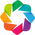

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
# Plot test results predictions vs actual
hv.extension('bokeh')
test_results_plot = test_results.hvplot(title = 'Happiness SVM SVR Model Testing Results: Predictions vs Actuals (2005-2021)\nR2=0.89',
                                          ylabel='Life Ladder', xlabel='Country-Year ID', fontscale=0.85)
test_results_plot

In [ ]:
# Evaluate metrics that describe how well the SVR model fit the observed data and explained the target
# R2, or coefficient of determination, for train data
score_train = svr_model.score(X_train, y_train)
score_train

0.9196639122604747

In [ ]:
# R2, or coefficient of determination, for test data.
score_test = svr_model.score(X_test, y_test)
score_test
# The model remained robust outside of the training data when exposed to the unseen test data

0.8926009651026436

In [ ]:
# Mean Squared Error (MSE) for train data: The average of the squared differences between predicted and actual values.
mse_trained = mean_squared_error(y_train, y_train_predictions)
mse_trained
# Note MSE within context of Life Ladder that averaged around 5 and varied between approximately 3 and 8.

0.10777219919492012

In [ ]:
# Mean Squared Error (MSE) for test data: The average of the squared differences between predicted and actual values.
mse_test =  mean_squared_error(y_test, y_test_predictions)
mse_test

0.13758843788598243

In [ ]:
# R2 for train data
# score() and r2_score are the same by definition, just specified differently in terms of its arguments.
# R2 is the coefficient of determination, or the multiple correlation squared, and represents the percentage of total variation in the target \n
# explained by the model's multiple regressors, or features.
r2_trained = r2_score(y_train, y_train_predictions)
r2_trained

0.9196639122604747

In [ ]:
# R2 for test data
# R-squared (R²) or Coefficient of Determination: Measures the proportion of the variance in the target variable that is explained by the model.
r2_test = r2_score(y_test, y_test_predictions)
r2_test

0.8926009651026436

In [ ]:
# Print releveant test metrics.
print(f"The score is {score_test}.")
print(f"The r2 is {r2_test}.")
print(f"The mean squared error is {mse_test}.")

The score is 0.8926009651026436.
The r2 is 0.8926009651026436.
The mean squared error is 0.13758843788598243.


 ## Create a Neural Network Model

In [ ]:
# Reference Tensorflow Keras modules used in neural network modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Evaluate shape of the standardized features dataset to inform neural net
X_standardized_recombined_df.shape

(1678, 164)

In [ ]:
# Evaluate shape of the pre-standardized features dataset to inform neural net
X.shape

(1678, 11)

In [ ]:
# Reference Tensorflow Keras modules used in neural network modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Instantiate the sequential neural network object.  The Functional object is a popular alternative, but not covered in this course.
neural_net = Sequential()

In [ ]:
# Define the model's parameters
node_multiplier = 2
number_inputs = 164
number_hidden_nodes = node_multiplier * X_standardized_recombined_df.shape[1]
#number_hidden_nodes = node_multiplier * X.shape[1]
#print(number_hidden_nodes)
number_classes = 1
# Observations: Keeping epochs constant at 50, the loss function struggled to \n
# converge to the SVR MSE when a 2-3 node multiplier was used on the pre-standardized \n
# features count of 11, and therefore the standardized features dataset count of 164 \n
# was relied on instead to inform the model.  Using a node_multiplier of 1-3 against \n
# the 164 features demonstrated reasonable convergence of the loss function, however, \n
# once the multiplier was dropped to 0.5, convergence was no longer satisfactory.

In [ ]:
# Add the input and hidden layer(s) to the model
# Occam's Razor/KISS. We will first attempt to model the problem with a single hidden layer
# Using ReLu as activation function instead of Linear to capture potential non-linear relations
neural_net.add(Dense(units = number_hidden_nodes, activation = "relu", input_dim = number_inputs))

In [ ]:
# Add the output layer(s) to the model
neural_net.add(Dense(units=number_classes, activation="relu"))

In [ ]:
# If we had more time we might pursue this functionality further.  However, in this case we know the structure of our data.
# neural_net.build(input_shape=())

In [ ]:
# Review the setup of our neural network model, layers, and parameters
neural_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 328)               54120     
                                                                 
 dense_3 (Dense)             (None, 1)                 329       
                                                                 
Total params: 54449 (212.69 KB)
Trainable params: 54449 (212.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the neural net
# Note that we shouldn't use the metric 'accuracy' in our regression problem because it is likely to be \n
# very low, if not zero, and is more suited for classification problems.
# If we had more time, we might turn the Life Ladder from a float/regression problem into a classification problem \n
# by using 'qcut' to convert the Life Ladder from float to a decile+1, or 11-quantile, rank spanning 0 to 10 \n
# since the underlying Life Ladder Gallup Poll is actually an integer survey from 0 to 10, and only then \n
# converted to a numeric average by country when compiled and reported in the global Happiness Report.
# neural_net.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) #Appropriate metrics version for a classification problem
neural_net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']) #Appropriate metrics version for a regression problem

In [ ]:
# Create our neural net model by fitting the neural net to our train data
# Each epoch, or iteration, through the entire training dataset represents a variation in the features' weights \n
# with the objective of reducing the loss function and increasing the accuracy with each epoch.  The epochs parameter \n
# initially is therefore a best guess before the loss function is observed.  If we had more time, we might import and use \n
# the Keras callback function 'keras.callbacks.callbacks.EarlyStopping()', which monitors during training the loss or accuracy \n
# function and halts training early when only a marginal benefit is seen in loss or accuracy.
iterations = 50
neural_net_model = neural_net.fit(X_train, y_train, epochs=iterations, shuffle=True) # If this were a time-series, shuffle should be False.

Epoch 1/50
40/40 [==============================] - 2s 4ms/step - loss: 15.7628 - mse: 15.7628
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 3.1181 - mse: 3.1181
Epoch 3/50
40/40 [==============================] - 0s 9ms/step - loss: 0.8501 - mse: 0.8501
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 0.5370 - mse: 0.5370
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.4708 - mse: 0.4708
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.4633 - mse: 0.4633
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 0.4601 - mse: 0.4601
Epoch 8/50
40/40 [==============================] - 0s 7ms/step - loss: 0.4601 - mse: 0.4601
Epoch 9/50
40/40 [==============================] - 0s 6ms/step - loss: 0.4225 - mse: 0.4225
Epoch 10/50
40/40 [==============================] - 0s 7ms/step - loss: 0.4218 - mse: 0.4218
Epoch 11/50
40/40 [==============================] - 0s 6ms/step - 

In [ ]:
# Create a DataFrame for the model's training history
neural_net_model_history_df = pd.DataFrame(neural_net_model.history, index=range(1, len(neural_net_model.history["loss"]) + 1))
display(neural_net_model_history_df.head())

,loss,mse
1,15.762815,15.762815
2,3.118115,3.118115
3,0.850111,0.850111
4,0.537045,0.537045
5,0.470767,0.470767


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
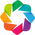

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
hv.extension('bokeh')
# Plot the model's training loss function history
neural_net_model_history_plot = neural_net_model_history_df.hvplot(title='Neural Net Model Loss Function Training History',
                                                                   ylabel='loss', xlabel='epoch')
neural_net_model_history_plot

In [ ]:
# Save the training model for future training and testing
# Set the file path name for the model
#file_path_nm = Path('neural_net_model.h5')
file_path_nm = Path('neural_net_model.keras')

# Export the model to the path as an HDF5 file
neural_net.save(file_path_nm)

In [ ]:
# Load the training model for testing
# This step not technically necessary for current notebook session, however, shown for demonstration purposes.
neural_net_imported = tf.keras.models.load_model(file_path_nm)

In [ ]:
# Review the model's loss and mse metrics for the test data using the evaluate method
model_loss, model_mse = neural_net_imported.evaluate(X_test, y_test, verbose=2)

# Evaluation metrics for the test data
print(f"Loss: {model_loss}, MSE: {model_mse}")

14/14 - 1s - loss: 0.4025 - mse: 0.4025 - 745ms/epoch - 53ms/step
Loss: 0.40246883034706116, MSE: 0.40246883034706116


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
